In [1]:
import json
import multiprocessing
import tempfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from gimpformats.gimpXcfDocument import GimpDocument
from PIL import Image
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map

from utils import DATA_VOL_PATH

/home/andrewhinh/Desktop/Projects/mho/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
response = requests.get(
    "https://api.figshare.com/v2/collections/6984822/articles?page_size=240"
)
data = response.json()
data[0], len(data)

({'id': 25807111,
  'title': 'Subject 74 co-registered scan 2',
  'doi': '10.6084/m9.figshare.25807111.v1',
  'handle': '',
  'url': 'https://api.figshare.com/v2/articles/25807111',
  'published_date': '2024-08-23T10:04:51Z',
  'thumb': 'https://s3-eu-west-1.amazonaws.com/ppreviews-npg-489897889/46283905/thumb.png',
  'defined_type': 3,
  'defined_type_name': 'dataset',
  'group_id': 2826,
  'url_private_api': 'https://api.figshare.com/v2/account/articles/25807111',
  'url_public_api': 'https://api.figshare.com/v2/articles/25807111',
  'url_private_html': 'https://figshare.com/account/articles/25807111',
  'url_public_html': 'https://springernature.figshare.com/articles/dataset/Subject_74_co-registered_scan_2/25807111',
  'timeline': {'posted': '2024-08-23T10:04:51',
   'firstOnline': '2024-08-23T10:04:51'},
  'resource_title': None,
  'resource_doi': None},
 213)

In [3]:
json_data = list(
    tqdm(
        thread_map(
            lambda x: json.loads(requests.get(x["url"]).text),
            data,
            max_workers=multiprocessing.cpu_count(),
        )
    )
)
json_data[0]

100%|██████████| 213/213 [00:00<00:00, 1325499.63it/s]


{'files': [{'id': 46283905,
   'name': '74.1_registered.jpeg',
   'size': 42749,
   'is_link_only': False,
   'download_url': 'https://ndownloader.figshare.com/files/46283905',
   'supplied_md5': 'a4d5b08b8c5c95cef42c4ed4249fbc5c',
   'computed_md5': 'a4d5b08b8c5c95cef42c4ed4249fbc5c',
   'mimetype': 'image/jpeg'}],
 'custom_fields': [{'name': 'Research Data Support', 'value': ''}],
 'authors': [{'id': 13918917,
   'full_name': 'Mariano Cabezas',
   'first_name': 'Mariano',
   'last_name': 'Cabezas',
   'is_active': False,
   'url_name': '_',
   'orcid_id': ''},
  {'id': 17659023,
   'full_name': 'Yago Diez',
   'first_name': 'Yago',
   'last_name': 'Diez',
   'is_active': False,
   'url_name': '_',
   'orcid_id': ''},
  {'id': 17659026,
   'full_name': 'Clara Martinez-Diago',
   'first_name': 'Clara',
   'last_name': 'Martinez-Diago',
   'is_active': False,
   'url_name': '_',
   'orcid_id': ''},
  {'id': 17659029,
   'full_name': 'Anna Maroto',
   'first_name': 'Anna',
   'last_name'

In [4]:
urls = [
    sample["files"][0]["download_url"]
    for sample in json_data
    if sample["files"][0]["mimetype"] == "image/x-xcf"
]
n_unique = len(urls)
n_unique

104

In [5]:
def clean_ux(image):
    """
    Function designed to clean the UX from a US image from Girona.

    :param image: Image with the UX.
    :return: a clean image without UX.
    """
    new_image = image.copy()
    new_image[:50, ...] = 0
    new_image[:150, -100:] = 0
    new_image[:, :40] = 0

    return new_image


def get_points(image):
    """
    Function designed to take an image with manually drawn points and return
    the set of coordinates for their centroid.

    :param image: RGB image with the point annotations.
    :return:  numpy aray with the centroids (points x coordinates).
    """
    # We us OpenCV to binarize the image and detect the points.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[gray > 0] = 255

    # We use OpenCV to compute the centroids of the annotated points.
    _, _, _, centroids = cv2.connectedComponentsWithStats(gray)

    # We ignore the background centroid (first and largest one).
    return centroids[1:]


def makeDict(names, points):
    """
    Given two lists of layers and another list with the lists of points in each layer at every position,
    create a dictionary with layer names as keys
    and the lists of points as values
    """
    return {names[i]: points[i] for i in range(len(names))}


def load_xcf(path):
    """
    Given the name of a xcf file, this functions reads it using GimpDocument,
    extract a list of images along with a list of layer names and returns them
    as two lists.
    :param path: Path to the image.
    :return: list of the layer names and their data (images).
    """

    # List data on groups followed by the direct children of a gimp xcf
    # document.
    project = GimpDocument(path)
    layers = project.layers
    # CAUTION: We are including the image. It's important if we only want the
    # coordinates of the annotatons, as we will need to ignore it!
    names, data = zip(
        *[(layer.name, layer.image) for layer in layers if not layer.isGroup]
    )
    labels = list(names)[:-1]
    annotations = list(data)[:-1]
    points = [get_points(np.array(x)) for x in annotations]
    image = clean_ux(np.array(data[-1])[..., 0])

    return image, labels, points


100%|██████████| 104/104 [00:00<00:00, 978043.98it/s]


{'calota': array([[545., 182.],
       [239., 273.],
       [652., 378.],
       [506., 490.]]), 'talems': array([[414., 275.],
       [372., 304.],
       [393., 351.]]), 'cerebel': array([[345., 213.],
       [298., 247.],
       [375., 269.],
       [297., 284.],
       [364., 302.],
       [275., 314.],
       [359., 332.],
       [303., 358.]]), 'cavum': array([[550., 328.],
       [517., 330.],
       [514., 357.],
       [550., 364.]]), 'silvio': array([[440., 441.],
       [514., 470.],
       [415., 472.]]), 'astes anteriors': array([[586., 308.],
       [573., 401.]]), 'linia mitja': array([[552., 356.],
       [606., 366.]])}


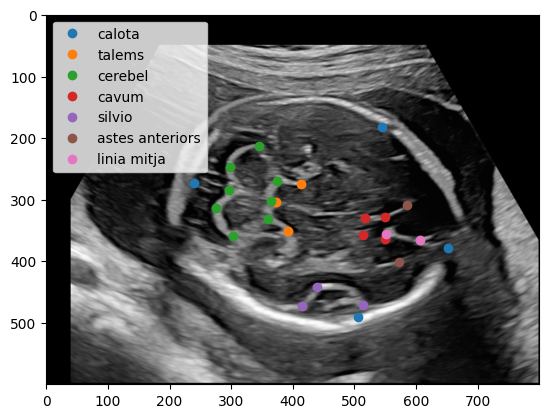

In [6]:
def process_xcf(url: str, i: int):
    xcf_data = requests.get(url).content
    tmp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".xcf").name
    with open(tmp_file, "wb") as f:
        f.write(xcf_data)
    image, labels, points = load_xcf(tmp_file)
    names_to_points = makeDict(labels, points)
    pil_image = Image.fromarray(image)
    img_path = DATA_VOL_PATH / f"{i}.png"
    pil_image.save(img_path)
    return names_to_points, i


xcfs = list(
    tqdm(
        thread_map(
            process_xcf,
            urls,
            range(n_unique),
            max_workers=multiprocessing.cpu_count(),
        )
    )
)

print(xcfs[0][0])  # names_to_points
plt.imshow(np.array(Image.open(DATA_VOL_PATH / f"{xcfs[0][1]}.png").convert("RGB")))
for label, points in xcfs[0][0].items():
    plt.plot(points[:, 0], points[:, 1], "o", label=label)
plt.legend()
plt.show()